In [160]:
from mss import mss 
import pydirectinput
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time 
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

In [161]:
class WebGame(Env):
    def __init__(self): 
        super().__init__()
        self.observation_space = Box(low=0, high= 255, shape = (1,100,120), dtype=np.uint8)
        self.action_space = Discrete(3) 
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width':600, 'height': 500}
        self.done_location = {'top': 250, 'left':450, 'width': 500, 'height': 70}
        
    
    def step(self, action):
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])
        done,done_cap = self.get_done()
        new_observation = self.get_observation()
        reward = 1
        info = {}
        truncated = False
        
        return new_observation,reward, done, truncated, info


    def render(self):
        cv2.imshow("game", np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
        
    def reset(self, seed = None):
        time.sleep(1)
        pydirectinput.click(x=150, y=150 )
        pydirectinput.press('space')
        info = {}
        return self.get_observation(), info  
    

    def close(self):
        cv2.destroyAllWindows()
        
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (120,100))
        channel = np.reshape(resized, (1,100,120))
        return channel
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        #ocr part
        done_strings = ['GAME', 'GAHE', "GANE"]
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap
env = WebGame()

In [162]:
env.render()

In [163]:
env.close()

In [164]:
env.reset()

(array([[[33, 33, 33, ..., 33, 33, 33],
         [33, 33, 33, ..., 33, 33, 33],
         [33, 33, 33, ..., 33, 33, 33],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]]], dtype=uint8),
 {})

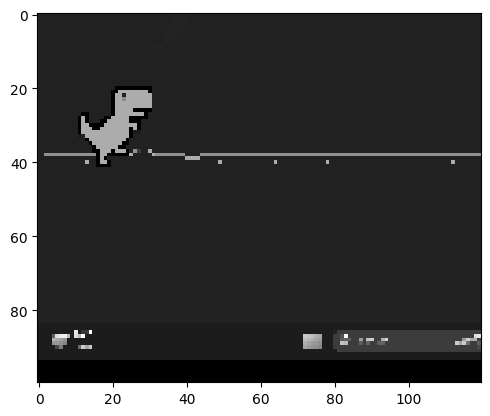

In [165]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [166]:
env.get_observation()

array([[[33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]]], dtype=uint8)

In [167]:
done, done_cap = env.get_done()

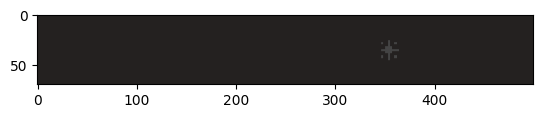

In [168]:
plt.imshow(done_cap)

In [169]:
done

False

TEST ENVIRONMENT

In [170]:
env = WebGame()

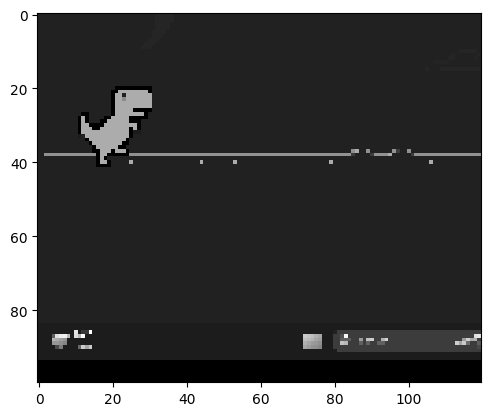

In [171]:
obs = env.get_observation()
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

In [172]:
done,done_cap = env.get_done()
print(done)

False


testing

In [173]:
# for episode in range(10):
#     obs = env.reset()
#     done = False
#     total_reward = 0
#     while not done:
#         obs,reward,done,info = env.step(env.action_space.sample())
#         total_reward+= reward
 
#     print(f'Total reward for episode{episode} is{total_reward}')


Training the DQN(Deep-Q-Network)

In [174]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker


In [175]:
env_checker.check_env(env)

In [176]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose = 1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok = True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [177]:
checkpoint_dir = './train/'
log_dir = './log/'

In [178]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=checkpoint_dir)

In [179]:
from stable_baselines3 import DQN

In [180]:
model = DQN("CnnPolicy", env, tensorboard_log=log_dir, verbose=1, 
            buffer_size=1000000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\muru9\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 24.02GB > 3.85GB
  warnings.warn(


In [ ]:
model.learn(total_timesteps=5000, callback=callback)

In [ ]:
model.load("train/best_model_50000")

In [ ]:
for ep in range(5):
    obs = env.reset()
    done = False
    total_reward=0
    while not done:
        action, _= model.predict(obs)
        obs,reward,done,truncated,info = env.step(int(action))
        tot_rew += reward